<a href="https://colab.research.google.com/github/cs3bastian/avavances-tecnologicos-IUTEPI/blob/main/proyectoavancesRNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.antes de empezar la RNA se debe configurar el bakend y las librerias que vamos a usar

In [7]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

2. descargamos los datos que vamos a usar mediante el link de los datos y el comando !curl

In [8]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  97.0M      0  0:00:08  0:00:08 --:--:--  113M


3. despues de descargar los datos los desconprimimos del archivo zip con este comando

In [9]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [10]:
!ls PetImages

Cat  Dog


4.ahora por medio de una funcion eliminamos las imagenes corruptas empezando porque todas esten en modo JPIG

In [11]:
num_skipped = 0 # creamos un contador que indique la cantidad de imagenes borradas
for folder_name in ("Cat", "Dog"): # un ciclo for que recorra las carpetas de perros y gatos
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")


Deleted 1590 images.


5.generamos una DATASETH que dividira las imagenes en baches de 128

In [12]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


6.Visualizar los datos
Aquí están las primeras 9 imágenes en el conjunto de datos de entrenamiento.

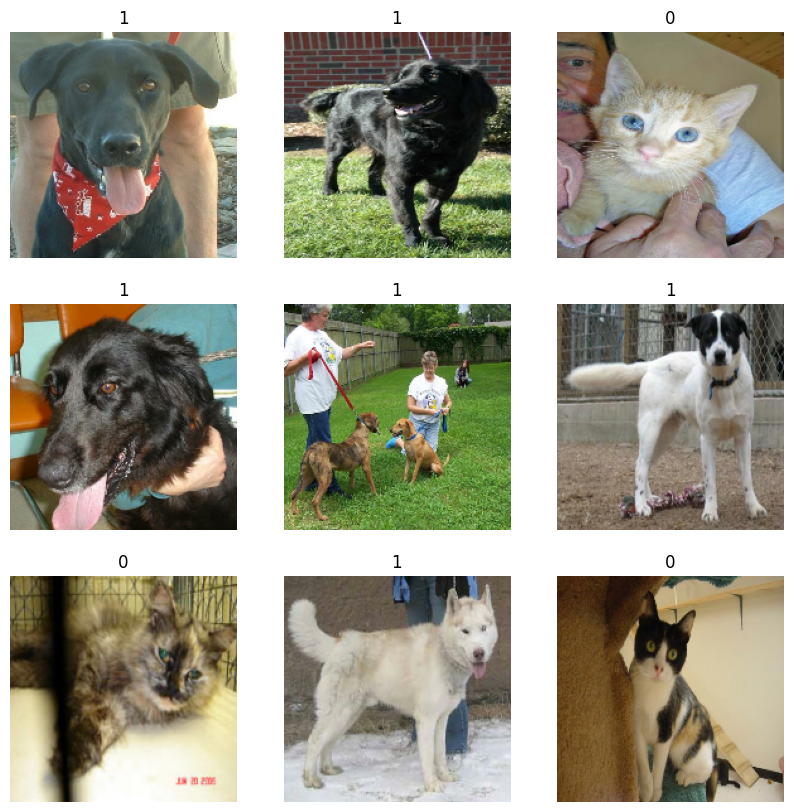

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

automaticamente el programa detecta que son carpetas distintas y los clasifica en 2 clases 1 para perros 0 para gatos

7.Uso del aumento de datos de imágenes
Cuando no se dispone de un conjunto de datos de imágenes extenso, conviene introducir artificialmente diversidad de muestras aplicando transformaciones aleatorias pero realistas a las imágenes de entrenamiento, como volteos horizontales aleatorios o pequeñas rotaciones aleatorias. Esto ayuda a exponer el modelo a diferentes aspectos de los datos de entrenamiento y, al mismo tiempo, reduce el sobreajuste.

In [14]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


8.Visualicemos cómo se ven las muestras aumentadas, aplicándolas data_augmentation repetidamente a las primeras imágenes del conjunto de datos:



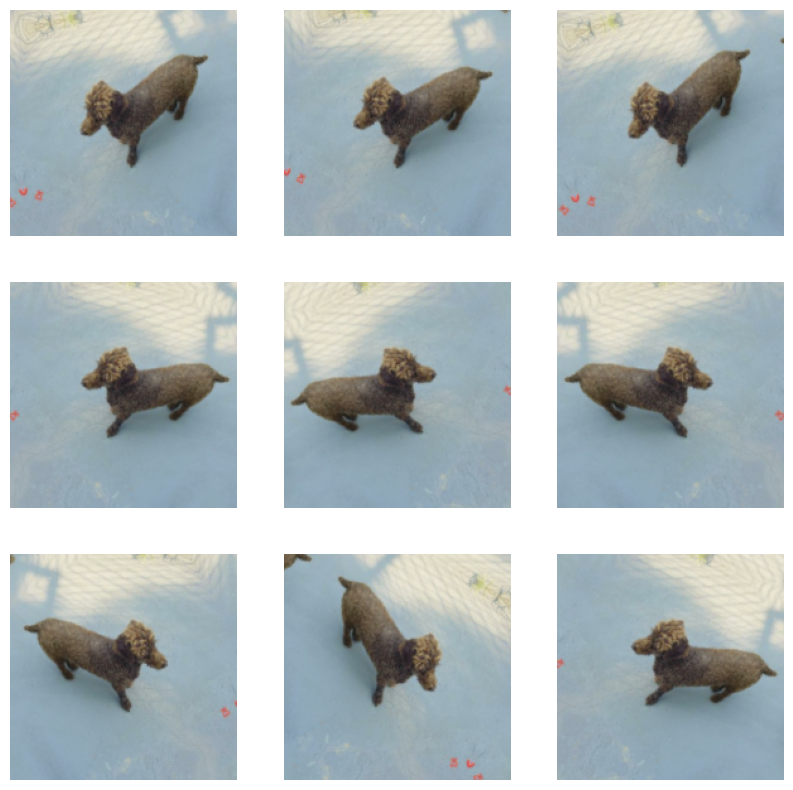

In [47]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[10]).astype("uint8"))
        plt.axis("off")

9.Estandarización de los datos
float32Nuestras imágenes ya tienen un tamaño estándar (180x180), ya que nuestro conjunto de datos las genera como lotes contiguos . Sin embargo, sus valores de canal RGB se encuentran dentro del [0, 255]rango. Esto no es ideal para una red neuronal; en general, se recomienda que los valores de entrada sean pequeños. Aquí, estandarizaremos los valores para que estén dentro del rango [0, 1]mediante una Rescalingcapa al inicio de nuestro modelo.



Dos opciones para preprocesar los datos:


In [17]:
inputs = keras.Input(shape=image_size + (3,)) # Use image_size to define the input shape and add the channel dimension
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
# ...  # Rest of the model

Con esta opción, el aumento de datos se realizará en el dispositivo , de forma sincronizada con el resto de la ejecución del modelo, lo que significa que se beneficiará de la aceleración de la GPU.

Tenga en cuenta que el aumento de datos está inactivo en el momento de la prueba, por lo que las muestras de entrada solo se aumentarán durante fit(), no cuando se llame evaluate()a o predict().

Si estás entrenando en GPU, esta puede ser una buena opción.

opcion 2: ojo con esta correcion que hizo gemini codigo origianl
  augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))


In [18]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x), y))

10.Con esta opción, la ampliación de sus datos se realizará en la CPU , de forma asincrónica, y se almacenarán en búfer antes de ingresar al modelo.

Si estás entrenando en CPU, esta es la mejor opción, ya que hace que el aumento de datos sea asincrónico y no bloqueante.

En nuestro caso, optaremos por la segunda opción. Si no está seguro de cuál elegir, esta segunda opción (preprocesamiento asíncrono) siempre es una buena opción.

11.Configurar el conjunto de datos para el rendimiento
Apliquemos aumento de datos a nuestro conjunto de datos de entrenamiento y asegurémonos de usar precarga en búfer para que podamos obtener datos del disco sin que la E/S se vuelva bloqueadora:

In [19]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)


12.
Construir un modelo
Construiremos una versión reducida de la red Xception. No hemos intentado optimizar la arquitectura en detalle; si desea realizar una búsqueda sistemática de la mejor configuración del modelo, considere usar KerasTuner .

Tenga en cuenta que:

Comenzamos el modelo con el data_augmentationpreprocesador, seguido de una Rescalingcapa.
Incluimos una Dropoutcapa antes de la capa de clasificación final.

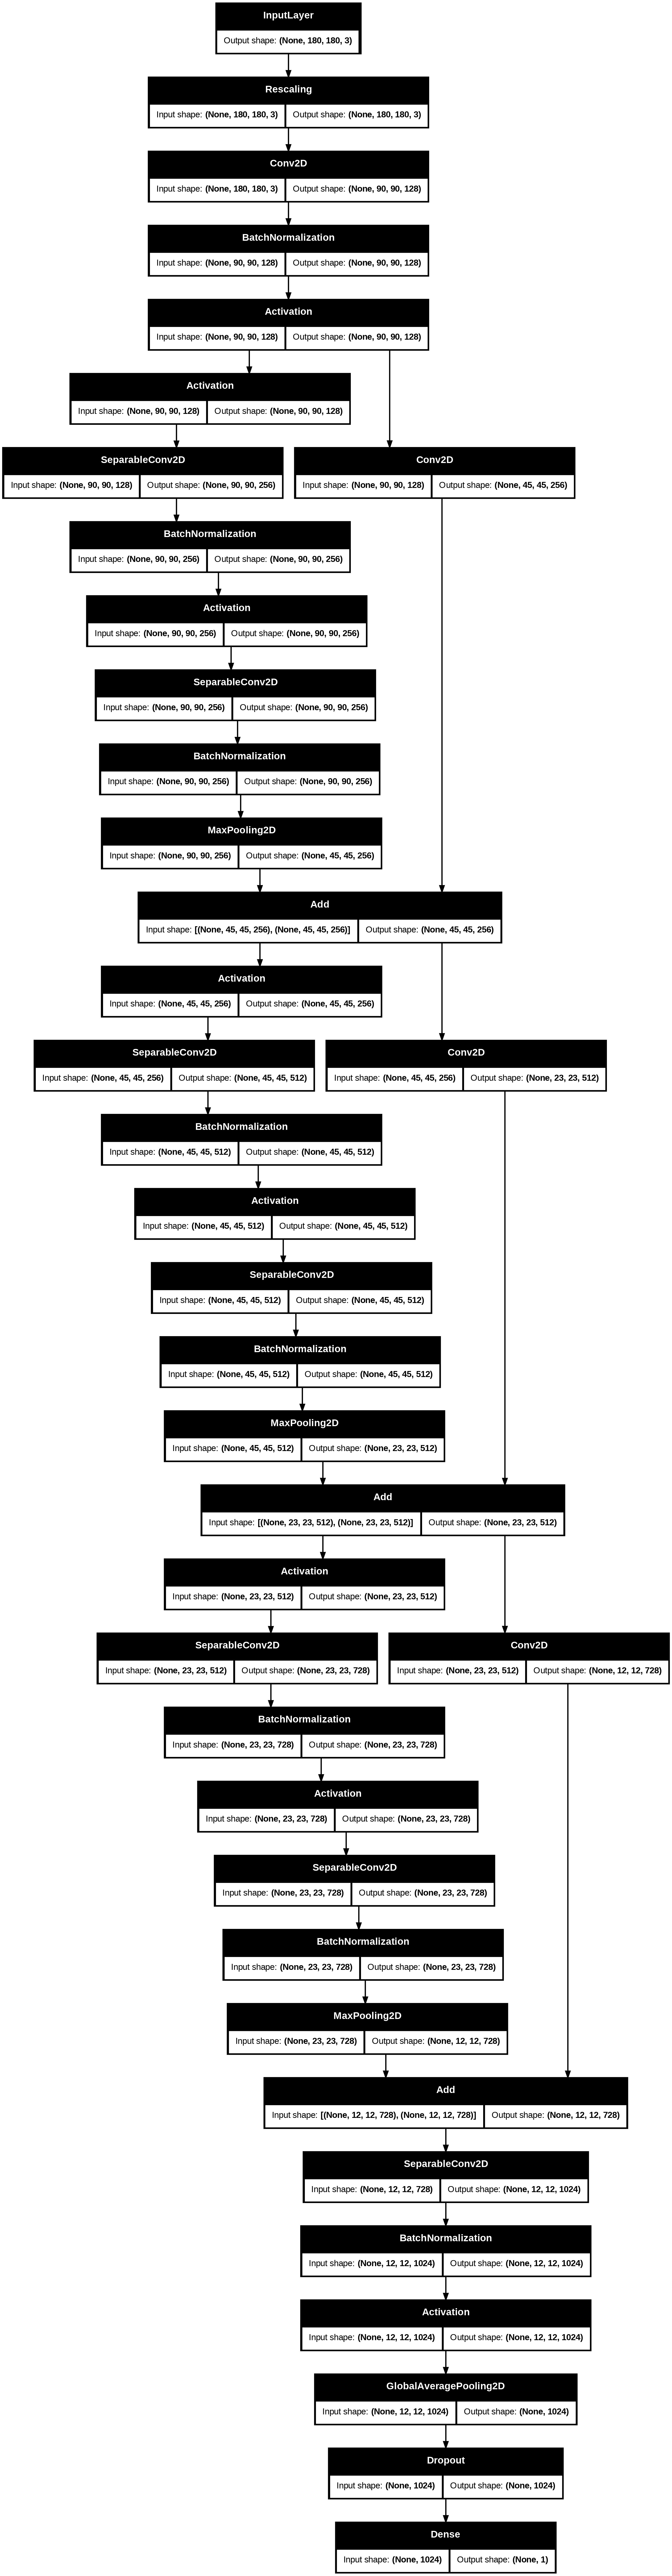

In [20]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

ENTRENAMOS EL MODELO:


In [48]:
#Entrenar el modelo
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/50


KeyboardInterrupt: 

13.
Ejecutar inferencias sobre nuevos datos
Tenga en cuenta que el aumento y la eliminación de datos están inactivos en el momento de la inferencia.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
This image is 100.00% cat and 0.00% dog.


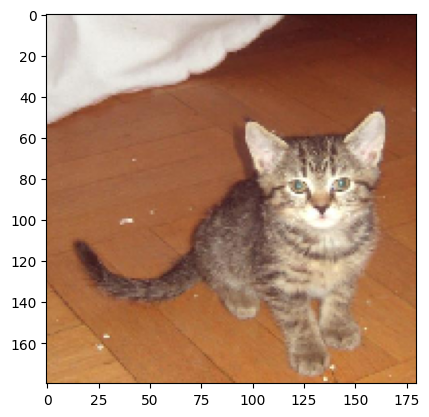

In [50]:
img = keras.utils.load_img("PetImages/Cat/5874.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")